# Per-Decision variance comparison
We want to inspect the differences in variance (by comparing the performances) of vanilla-POIS versus Per-Decision-POIS (PD-POIS).
We start by loading the necessary data from sacred file storage.

In [1]:
import sys
sys.path = ['..'] + sys.path
import pandas as pd
import numpy as np
import glob, sys, json, re
import matplotlib.pyplot as plt
import scipy.stats as sts
from sacred_notebook_utils import plot_mean_ci, plot_all
from baselines.common.sacred_utils import load_runs, filter_runs

First we need to load all the runs from the sacred dataset.

In [2]:
runs = load_runs('../../../sacred_data/sacred_runs_master/')
print("Loaded runs:", len(runs.keys()))
final_runs = load_runs('../../../sacred_data/sacred_runs_final/')
print("Loaded final runs:", len(final_runs.keys()))

Loaded runs: 572
Loaded final runs: 704


In [3]:
pdisnn_runs_local = load_runs('../sacred_pdisnn/')
print("Loaded pdisnn runs:", len(pdisnn_runs_local.keys()))

Loaded pdisnn runs: 134


In [4]:
# Merge the runs
total_runs = {}
for key, value in final_runs.items():
    total_runs[str(key) + '-final'] = value
for key, value in pdisnn_runs_local.items():
    total_runs[str(key) + '-local'] = value

We also create a base query which will be used throughout this notebook:

In [5]:
base_query = {
    'run.status': 'COMPLETED',
    'config.center': True,
    'config.gamma': 0.99,
    'config.clipping': False,
    'config.njobs': 1,
    'config.natural': False,
    'config.policy': 'linear',
    'config.iw_norm': 'none'
}

These properties are common to each experiment here.

## CartPole with 100 episodes
We start by inspecting the CartPole environment, using 100 episodes for each iteration as used in the paper. Since Per-Decision POIS seemed to get stuck in some situations, we also tried to enforce exploration through an entropy bonus. This entropy bonus is given only in the first 100 iterations (over a total of 500 iterations), and is scaled by a factor of 10 (which was found after some experiments).

----------------------------------------
Method: is  - Entropy: none
Experiments: 5
Seeds: 570, 160, 10, 904, 109
----------------------------------------
Method: is  - Entropy: step:10.0:100
Experiments: 5
Seeds: 904, 10, 570, 109, 160
----------------------------------------
Method: pdis  - Entropy: none
Experiments: 20
Seeds: 307, 247, 545, 947, 963, 178, 153, 315, 904, 236, 100, 10, 746, 950, 160, 689, 109, 570, 42, 662
----------------------------------------
Method: pdis  - Entropy: step:10.0:100
Experiments: 5
Seeds: 160, 904, 570, 109, 10


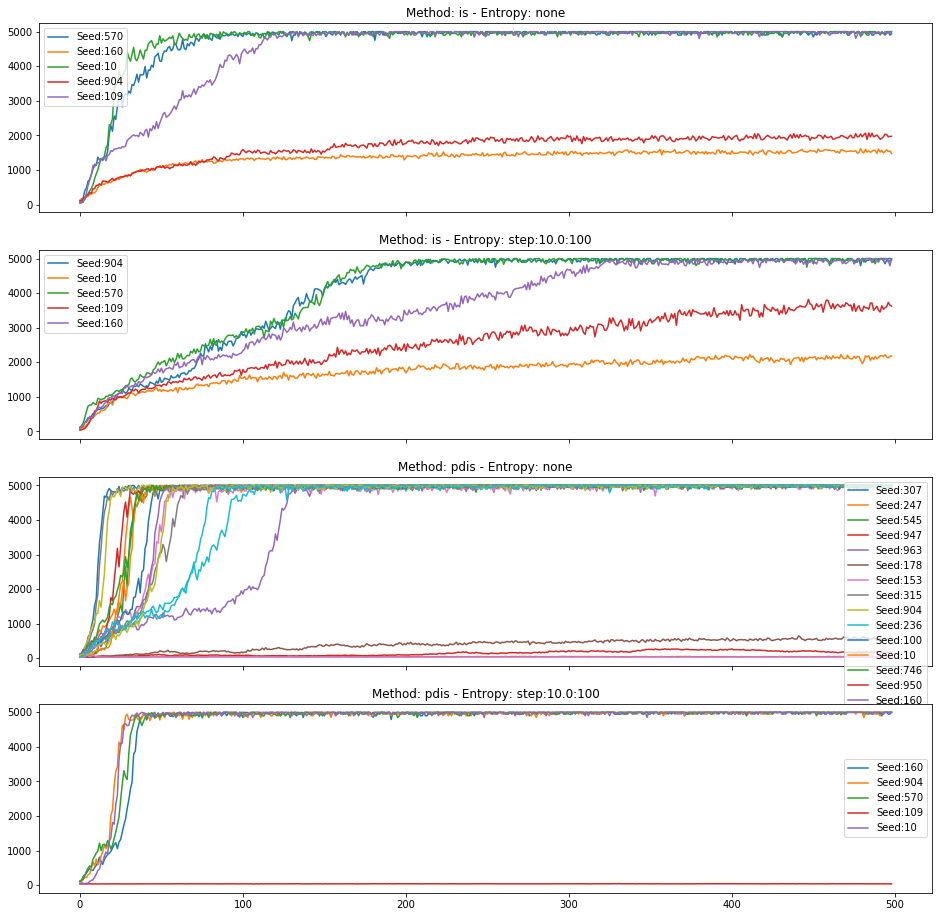

In [4]:
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, entropy) in enumerate([('is', 'max-d2', 'none'),
                                              ('is', 'max-d2', 'step:10.0:100'), 
                                              ('pdis', 'pdis-d2', 'none'), 
                                              ('pdis', 'pdis-d2', 'step:10.0:100')]):
    query = {
        'config.entropy': entropy,
        'config.env': 'cartpole',
        'config.iw_method': method,
        'config.delta': 0.4,
        'config.bound': bound,
        'config.num_episodes': 100
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Method:", method, " - Entropy:", entropy)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Entropy: " + entropy)
plt.show();

As we can see, the PD has a steeper ascent towards the optimal performance, which could indicate less variance in the estimation of the J. This experiment also shows how PD can get stuck in some cases (in particular seeds). In this case, this is not even mitigated by the initial entropy bonus.
We also notice how the entropy bonus slows the vanilla estimator while providing slightly better performances over time.

**UPDATE October 2018**
As we can see, PD remains stuck in 3 runs over 20 (15%), so it is a problem to take in account when using PD.

## CartPole using 20 episodes
To check if the PD estimator has, in fact, less variance, we want to reduce the number of episodes per iteration, which increases the variance. We will use 20 episodes per iteration.

----------------------------------------
Method: is  - Entropy: none
Experiments: 5
Seeds: 904, 109, 160, 10, 570
----------------------------------------
Method: is  - Entropy: step:10.0:100
Experiments: 5
Seeds: 109, 10, 904, 570, 160
----------------------------------------
Method: pdis  - Entropy: none
Experiments: 5
Seeds: 10, 160, 904, 570, 109
----------------------------------------
Method: pdis  - Entropy: step:10.0:100
Experiments: 5
Seeds: 904, 160, 570, 109, 10


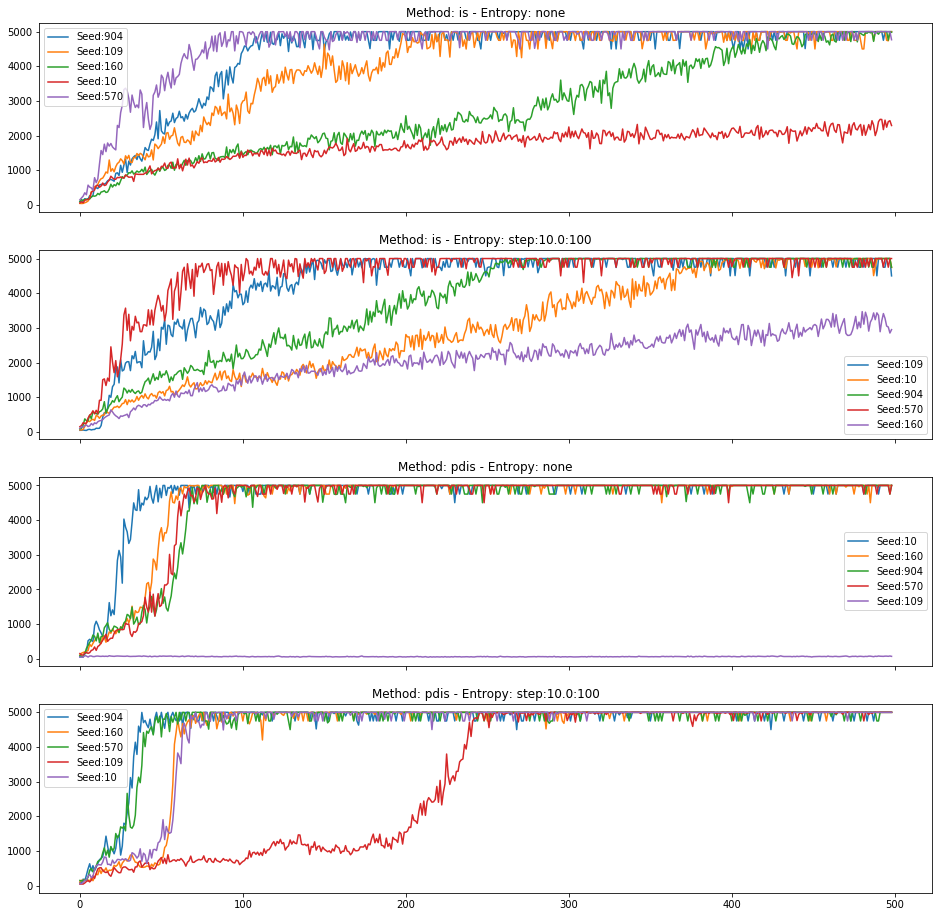

In [5]:
fig, axis = plt.subplots(nrows=4, ncols=1, figsize=(16,16), sharex=True, sharey=True)
for i, (method, bound, entropy) in enumerate([('is', 'max-d2', 'none'),
                                              ('is', 'max-d2', 'step:10.0:100'), 
                                              ('pdis', 'pdis-d2', 'none'), 
                                              ('pdis', 'pdis-d2', 'step:10.0:100')]):
    query = {
        'config.entropy': entropy,
        'config.env': 'cartpole',
        'config.iw_method': method,
        'config.delta': 0.4,
        'config.bound': bound,
        'config.num_episodes': 20
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Method:", method, " - Entropy:", entropy)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i])
    axis[i].set_title("Method: " + method + " - Entropy: " + entropy)
plt.show();

As we expected, the PD estimator is much faster in the performance increase, probably because the higher variance in the vanilla estimator makes it more unstable.
We also notice how in the PD estimator with the entropy bonus, there is no run which gets stuck (while increasing slowly). This could indicate how the reduced variance of the estimator could also cause stationary (and wrong) solutions.

# Inverted-Double Pendulum with 100 episodes
Now we want to replicate all these experiment in another environment, namely the Inverted-Double-Pendulum. This environment does not get solved entirely using control-based POIS, which can be noted from the following plots.

In [6]:
base_query['config.center'] = False

----------------------------------------
Method: is  - Entropy: none
Experiments: 5
Seeds: 109, 570, 160, 904, 10
----------------------------------------
Method: is  - Entropy: step:10.0:100
Experiments: 5
Seeds: 904, 10, 109, 160, 570
----------------------------------------
Method: pdis  - Entropy: none
Experiments: 5
Seeds: 160, 10, 109, 570, 904
----------------------------------------
Method: pdis  - Entropy: step:10.0:100
Experiments: 5
Seeds: 570, 904, 10, 160, 109


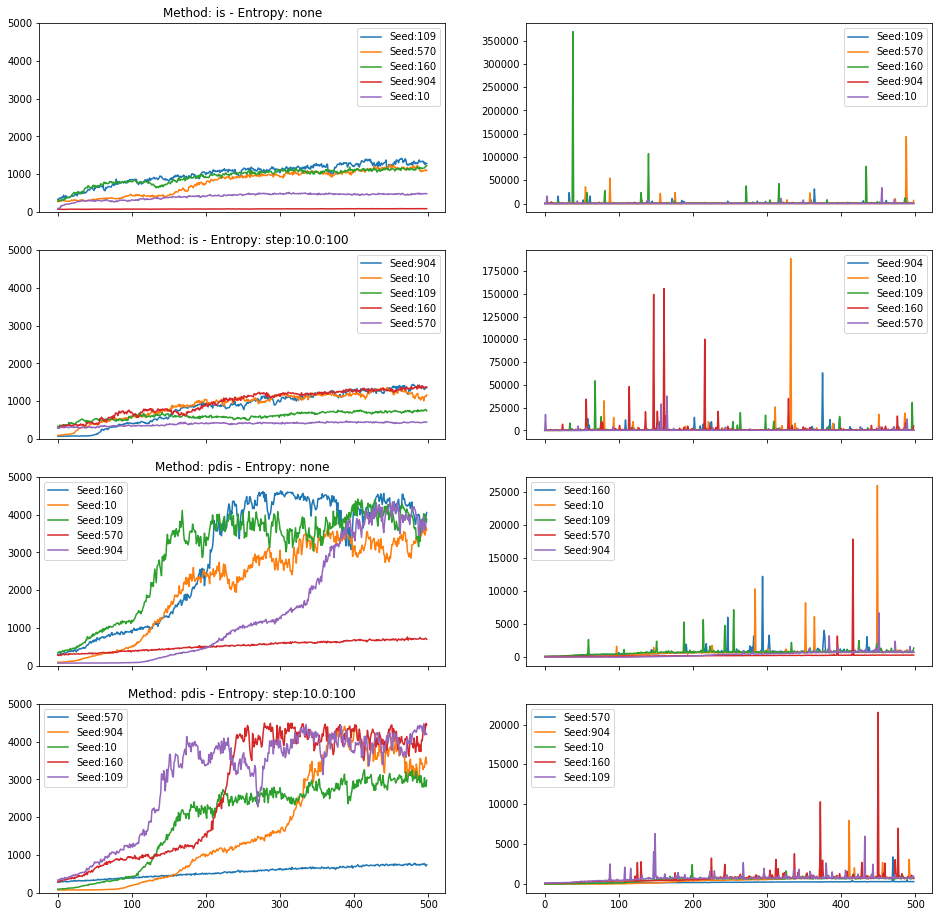

In [7]:
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,16), sharex=True, sharey=False)
for i, (method, bound, entropy) in enumerate([('is', 'max-d2', 'none'),
                                              ('is', 'max-d2', 'step:10.0:100'), 
                                              ('pdis', 'pdis-d2', 'none'), 
                                              ('pdis', 'pdis-d2', 'step:10.0:100')]):
    query = {
        'config.entropy': entropy,
        'config.env': 'inverted-double-pendulum',
        'config.iw_method': method,
        'config.delta': 0.1,
        'config.bound': bound,
        'config.num_episodes': 100
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Method:", method, " - Entropy:", entropy)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i,0])
    axis[i,0].set_ylim(0, 5000)
    plot_all(filtered_runs, 'Bound', axis[i,1])
    axis[i, 0].set_title("Method: " + method + " - Entropy: " + entropy)
plt.show();

These plots also show how, again, the PD method gets stuck in local minima, even when applying the entropy bonus. We plotted also the total perfomance, which includes the J and the variance bound, which is the quantity that gets optimized. We can see how the performance of the PD estimator is always negative, while normally this quantity is rather positive (considered the positive reward).
This indicates that the variance bound is quite strict in this case, and could limit the learning capabilities.

## Inverted Double Pendulum with 20 episodes
We now replicate the same experiment with 20 episodes per iteration for the Inverted-Double-Pendulum environment.

----------------------------------------
Method: is  - Entropy: none
Experiments: 5
Seeds: 160, 570, 109, 10, 904
----------------------------------------
Method: is  - Entropy: step:10.0:100
Experiments: 5
Seeds: 570, 10, 904, 109, 160
----------------------------------------
Method: pdis  - Entropy: none
Experiments: 5
Seeds: 10, 160, 109, 904, 570
----------------------------------------
Method: pdis  - Entropy: step:10.0:100
Experiments: 5
Seeds: 109, 10, 160, 570, 904


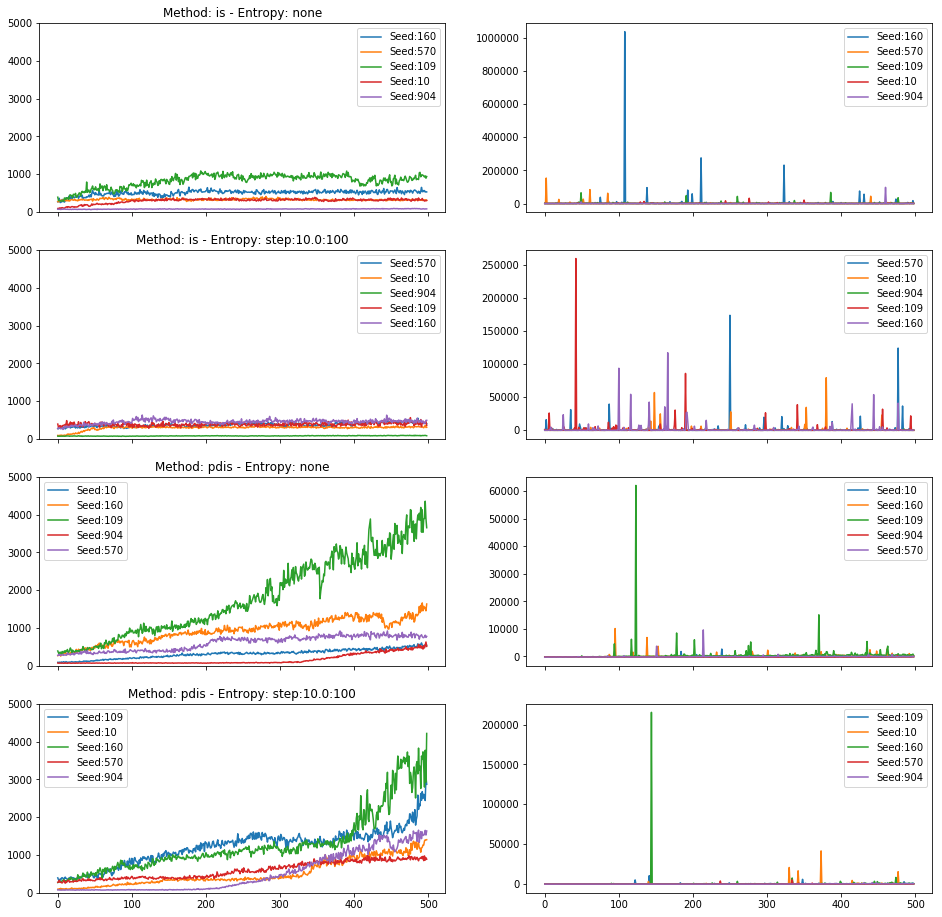

In [8]:
base_query['config.center'] = False
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,16), sharex=True, sharey=False)
for i, (method, bound, entropy) in enumerate([('is', 'max-d2', 'none'),
                                              ('is', 'max-d2', 'step:10.0:100'), 
                                              ('pdis', 'pdis-d2', 'none'), 
                                              ('pdis', 'pdis-d2', 'step:10.0:100')]):
    query = {
        'config.entropy': entropy,
        'config.env': 'inverted-double-pendulum',
        'config.iw_method': method,
        'config.delta': 0.1,
        'config.bound': bound,
        'config.num_episodes': 20
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Method:", method, " - Entropy:", entropy)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i,0])
    plot_all(filtered_runs, 'Bound', axis[i,1])
    axis[i,0].set_ylim(0, 5000)
    axis[i, 0].set_title("Method: " + method + " - Entropy: " + entropy)
plt.show();

This time, we see how also the vanilla estimator gets practically stuck in a local optima. We again point out that the bound on the PD estimator is negative, even more in this case (which is compatible with the variance increase due to the reduced episodes per iteration).

## Different deltas
Because of the negative bound on the PD estimator in the last case, we want to inspect what happens for different levels of delta, which scales the variance penalization.
(Experiments with delta 0.8, 0.9 and 0.99 are still running)

No handles with labels found to put in legend.
No handles with labels found to put in legend.


----------------------------------------
Delta: 0.2
Experiments: 5
Seeds: 109, 10, 904, 160, 570
----------------------------------------
Delta: 0.4
Experiments: 5
Seeds: 10, 570, 160, 904, 109
----------------------------------------
Delta: 0.6
Experiments: 5
Seeds: 570, 109, 904, 160, 10
----------------------------------------
Delta: 0.8
Experiments: 0
Seeds: 


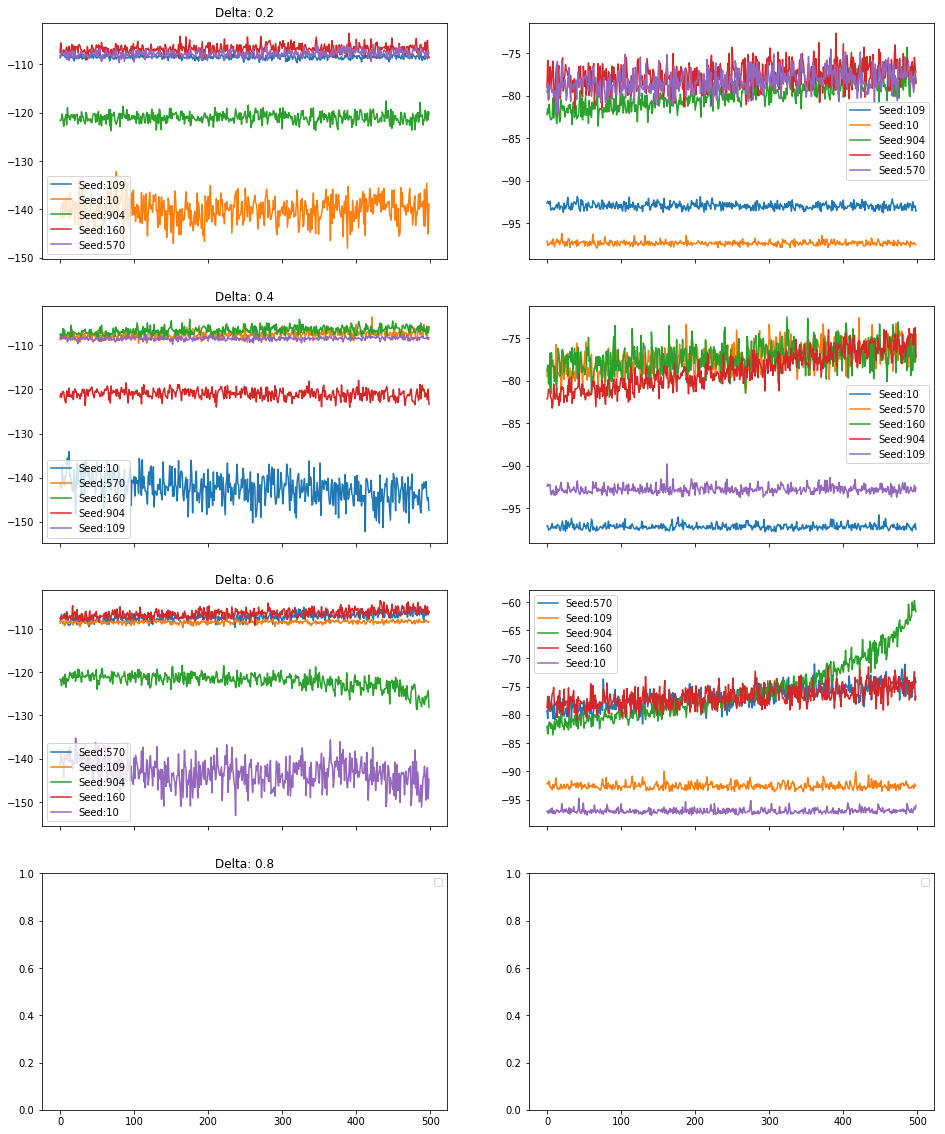

In [9]:
base_query['config.center'] = False
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,20), sharex=True, sharey=False)
for i, delta in enumerate([0.2, 0.4, 0.6, 0.8]):
    query = {
        'config.entropy': 'none',
        'config.env': 'inverted-pendulum',
        'config.iw_method': 'pdis',
        'config.delta': delta,
        'config.bound': 'pdis-d2',
        'config.num_episodes': 100
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i,0])
    plot_all(filtered_runs, 'ReturnMeanIW', axis[i,1])
    axis[i, 0].set_title("Delta: " + str(delta))
plt.show();  

----------------------------------------
Delta: 0.2
Experiments: 5
Seeds: 904, 570, 10, 160, 109
----------------------------------------
Delta: 0.4
Experiments: 5
Seeds: 109, 160, 904, 10, 570
----------------------------------------
Delta: 0.6
Experiments: 5
Seeds: 10, 570, 109, 904, 160
----------------------------------------
Delta: 0.8
Experiments: 5
Seeds: 109, 160, 904, 10, 570


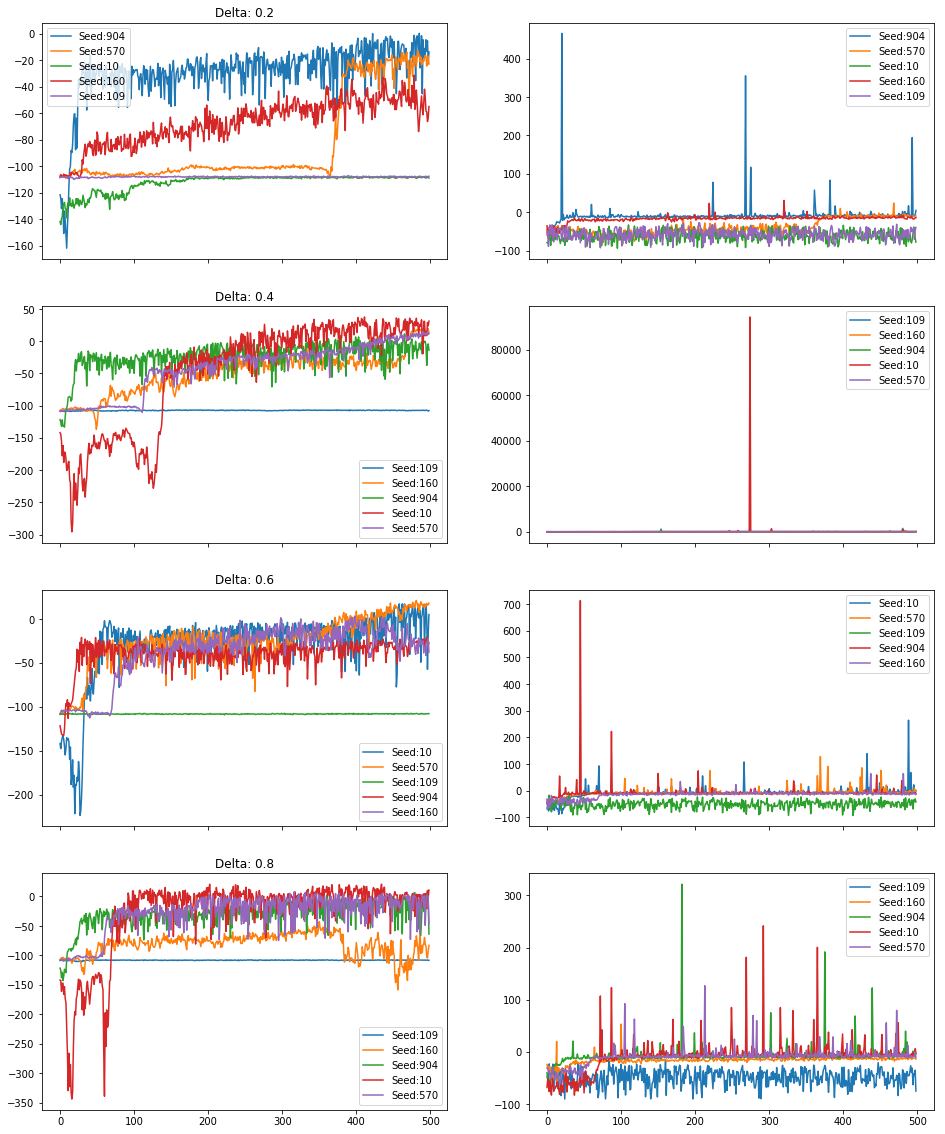

In [10]:
base_query['config.center'] = False
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,20), sharex=True, sharey=False)
for i, delta in enumerate([0.2, 0.4, 0.6, 0.8]):
    query = {
        'config.entropy': 'step:10.0:100',
        'config.env': 'inverted-pendulum',
        'config.iw_method': 'pdis',
        'config.delta': delta,
        'config.bound': 'pdis-d2-mean',
        'config.num_episodes': 100
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Delta:", delta)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i,0])
    plot_all(filtered_runs, 'ReturnMeanIW', axis[i,1])
    axis[i, 0].set_title("Delta: " + str(delta))
plt.show();  

## Zeros initialization

----------------------------------------
Env: rllab.cartpole
Experiments: 5
Seeds: 160, 570, 109, 10, 904
----------------------------------------
Env: rllab.acrobot
Experiments: 5
Seeds: 10, 904, 109, 160, 570
----------------------------------------
Env: rllab.mountain-car
Experiments: 5
Seeds: 904, 10, 160, 570, 109
----------------------------------------
Env: rllab.inverted-pendulum
Experiments: 5
Seeds: 570, 904, 109, 10, 160


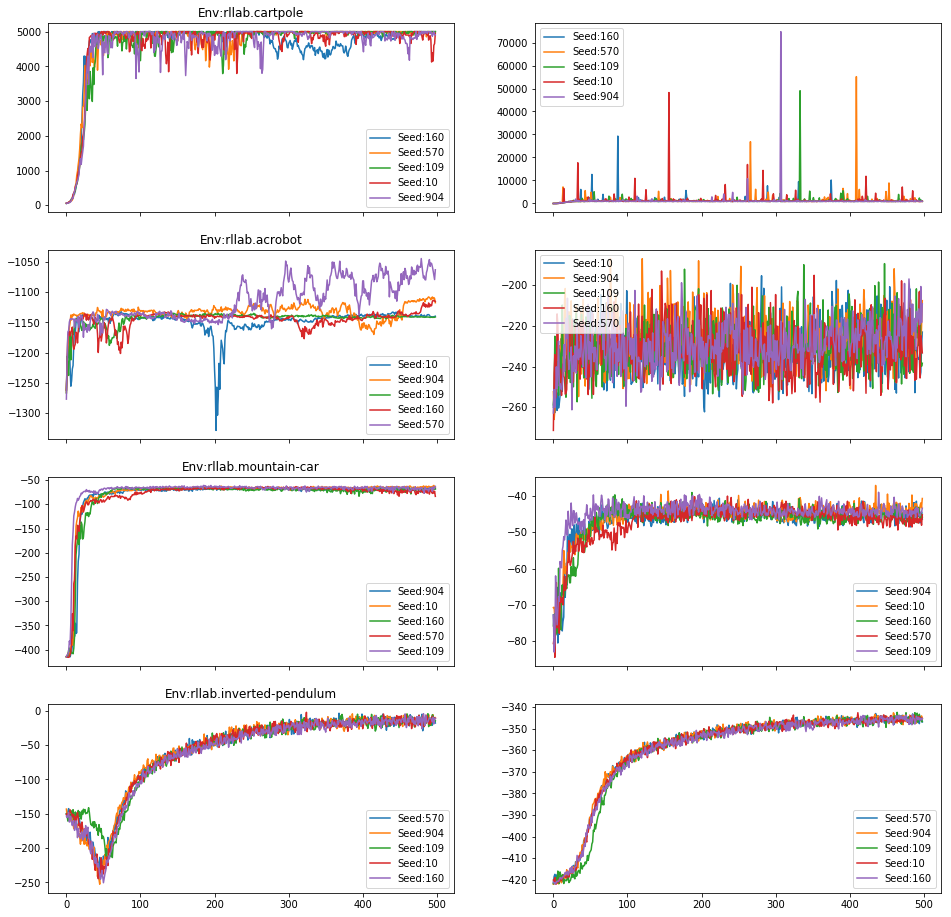

In [11]:
base_query['config.center'] = False
fig, axis = plt.subplots(nrows=4, ncols=2, figsize=(16,16), sharex=True, sharey=False)
for i, (env, delta, init) in enumerate([('rllab.cartpole', 0.3, 'zeros'),
                                        ('rllab.acrobot', 0.7, 'zeros'),
                                        ('rllab.mountain-car', 0.9, 'zeros'),
                                        ('rllab.inverted-pendulum', 0.9, 'zeros'),
                                       ]):
    query = {
        'config.env': env,
        'config.iw_method': 'pdis',
        'config.delta': delta,
        'config.bound': 'pdis-max-d2'
    }
    filtered_runs = filter_runs({**base_query, **query}, runs)
    print('----------------------------------------')
    print("Env:", env)
    print("Experiments:", len(filtered_runs.keys()))
    print("Seeds:", ", ".join(map(str, [filtered_runs[key]['config']['seed'] for key in filtered_runs.keys()])))
    plot_all(filtered_runs, 'EpRewMean', axis[i,0])
    plot_all(filtered_runs, 'Bound', axis[i,1])
    axis[i, 0].set_title("Env:" + env)
plt.show();